In [1]:
%reset -f
# librosa library
import librosa
import librosa.display

# Audio player
import soundfile as sf
import sounddevice as sd

# Listening a .wav file
from IPython.display import Audio

# classic libraries
import numpy as np
import matplotlib.pyplot as plt

# Images libraries
import PIL
from PIL import Image
import cv2

# scipy for signal processing
import scipy
import scipy.signal
import scipy.io.wavfile

# libraires home-made
import utils

# system libraries
import os
from tqdm import tqdm

# tensorflow et keras
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet, VGG16, ResNet50 # Transfer learning

# preprocessing by keras
from tensorflow.keras.applications.resnet50 import preprocess_input #optionnel
from tensorflow.keras.preprocessing.image import ImageDataGenerator #optionnel
from tensorflow.keras.utils import to_categorical

# split data in train-test
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime

# plot confusion matrix with colors
import seaborn as sns

C:\Users\ngotr\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# 1. Read data as the images

In [2]:
# Define the directory where your TIFF images are stored.
data_dir = 'data_img'

# Create empty lists to store image paths and their corresponding labels.
image_paths = []
labels = []

# Loop through the files in the data directory to collect image paths and labels.
for filename in os.listdir(data_dir):
    if filename.endswith(".tiff"):
        image_path = os.path.join(data_dir, filename)
        label = filename.split('_')[0]  # Assuming labels are in the format 'label_xx_yy.tiff'
        
        image_paths.append(image_path)
        labels.append(label)

# Convert lists to NumPy arrays for easier manipulation.
image_paths = np.array(image_paths)
labels = np.array(labels)

## 1.1 Read images and stock in a numpy array then save on hard-disc

## 1.2 Load numpy array that we saved before

In [3]:
data_load = np.load('data.npy')
print(data_load.shape)
data_load = (data_load - np.min(data_load))/((np.max(data_load)-np.min(data_load)))

(30000, 64, 64)


## 1.3 Split in train-validation-test

In [4]:
# Split the data into training and testing sets, stratified by labels.
train_images_full, test_images, train_labels_full, test_labels = train_test_split(data_load, labels, test_size=0.1, random_state=42, stratify=labels)
# Split the data into training and testing sets, stratified by labels.
train_images, val_images, train_labels, val_labels = train_test_split(train_images_full,train_labels_full, test_size=0.25, random_state=42, shuffle = True)
# You can print the distribution of labels in the training and testing sets if needed.
print("Training labels distribution:", np.unique(train_labels, return_counts=True))
print("Validation labels distribution:", np.unique(val_labels, return_counts=True))
print("Testing labels distribution:", np.unique(test_labels, return_counts=True))

Training labels distribution: (array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1'), array([2016, 2032, 2018, 2046, 2007, 2016, 2055, 2019, 2026, 2015],
      dtype=int64))
Validation labels distribution: (array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1'), array([684, 668, 682, 654, 693, 684, 645, 681, 674, 685], dtype=int64))
Testing labels distribution: (array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1'), array([300, 300, 300, 300, 300, 300, 300, 300, 300, 300], dtype=int64))


## 1.4 Distribution of train-validation-test

Class 0: 2016 samples (0)
Class 1: 2032 samples (1)
Class 2: 2018 samples (2)
Class 3: 2046 samples (3)
Class 4: 2007 samples (4)
Class 5: 2016 samples (5)
Class 6: 2055 samples (6)
Class 7: 2019 samples (7)
Class 8: 2026 samples (8)
Class 9: 2015 samples (9)


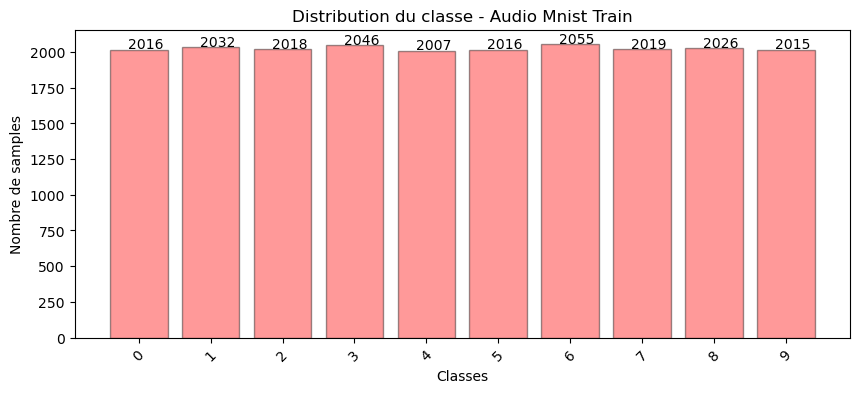

Class 0: 684 samples (0)
Class 1: 668 samples (1)
Class 2: 682 samples (2)
Class 3: 654 samples (3)
Class 4: 693 samples (4)
Class 5: 684 samples (5)
Class 6: 645 samples (6)
Class 7: 681 samples (7)
Class 8: 674 samples (8)
Class 9: 685 samples (9)


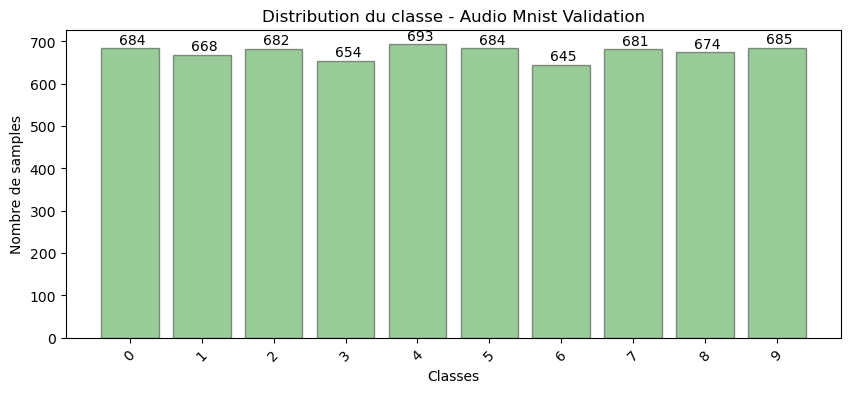

Class 0: 300 samples (0)
Class 1: 300 samples (1)
Class 2: 300 samples (2)
Class 3: 300 samples (3)
Class 4: 300 samples (4)
Class 5: 300 samples (5)
Class 6: 300 samples (6)
Class 7: 300 samples (7)
Class 8: 300 samples (8)
Class 9: 300 samples (9)


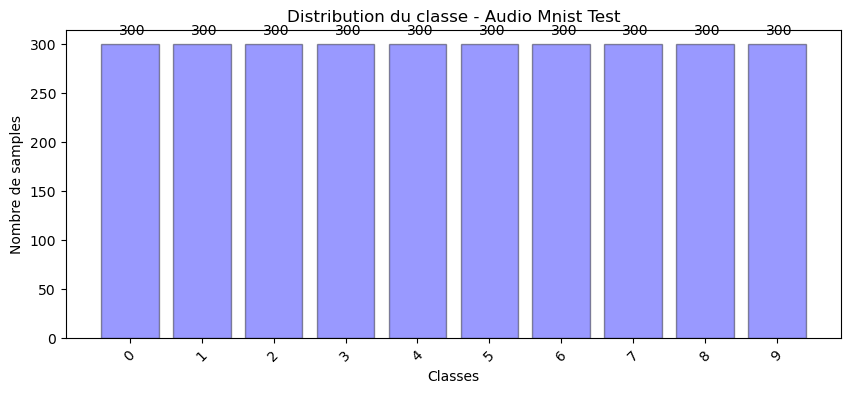

In [5]:
batch = [train_labels,val_labels,test_labels]
batch_name = ['Train','Validation','Test']
batch_color = ['red','green','blue']
# Calculate the number of samples for each class
for i in range(3):
    class_counts_train = tf.math.bincount(batch[i].flatten())
    num_classes = class_counts_train.shape[0]
    class_name_all = ['0','1','2','3','4','5','6','7','8','9'] 

    num_samples_list = []
    # Print the number of samples for each class
    for class_id, class_name in zip(range(num_classes), class_name_all):
        num_samples = class_counts_train[class_id].numpy()
        num_samples_list.append(num_samples)
        print(f"Class {class_id}: {num_samples} samples ({class_name})")

    plt.figure(figsize=(10, 4))
    bars = plt.bar(class_name_all, num_samples_list, alpha=0.4, color=batch_color[i], edgecolor='black')  # Adjust color and edgecolor
    plt.xlabel('Classes')
    plt.ylabel('Nombre de samples')
    plt.title('Distribution du classe - Audio Mnist ' + batch_name[i])
    plt.xticks(rotation=45)

    # Add labels on top of each bar
    for bar, num_samples in zip(bars, num_samples_list):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 10, str(num_samples), fontsize=10, color='black')
    plt.show()

In [6]:
x_train = train_images
x_val = val_images
x_test = test_images
y_train = np.array([int(label) for label in train_labels])
y_val = np.array([int(label) for label in val_labels])
y_test = np.array([int(label) for label in test_labels])

# 2. Configuration hyperparmeters and models (VGGlike and Dense)

## 2.1 Define hyperparameters

In [7]:
# Hyperparamètre
epoch = 10
batch_size = 256
lr = 0.0001
num_class = 10
drop_out = 0.3
input_shape=(64, 64, 1)
optimiseur = tf.keras.optimizers.Adam(learning_rate = lr)

## 2.2 Build VGGLike model and train

### 2.2.1 Build model, compile and fit

In [8]:
# Define the CNN model
VGGlike = Sequential()

# Convolutional layers
VGGlike.add(layers.Conv2D(64, activation='relu', input_shape= input_shape, padding = 'same', kernel_size = (3,3)))
VGGlike.add(layers.MaxPooling2D(pool_size=2))
VGGlike.add(layers.Conv2D(128, activation='relu', padding = 'same', kernel_size = (3,3)))
VGGlike.add(layers.MaxPooling2D(pool_size=2))
VGGlike.add(layers.Conv2D(256, activation='relu', padding = 'same', kernel_size = (3,3)))
VGGlike.add(layers.MaxPooling2D(pool_size=2))
VGGlike.add(layers.Flatten())
VGGlike.add(layers.Dense(10, activation='softmax'))

VGGlike.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 256)         0

In [9]:
VGGlike.compile(optimizer=optimiseur, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train
t1 = datetime.now()
hist_VGGlike = VGGlike.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, validation_data=(x_val, y_val),shuffle=True, workers = 20)
t2 = datetime.now()
duree_vgglike = t2-t1

Epoch 1/10
80/80 [==============================] - 65s 797ms/step - loss: 1.6154 - accuracy: 0.5744 - val_loss: 0.3797 - val_accuracy: 0.9138
Epoch 2/10
80/80 [==============================] - 66s 829ms/step - loss: 0.2169 - accuracy: 0.9384 - val_loss: 0.1597 - val_accuracy: 0.9516
Epoch 3/10
80/80 [==============================] - 77s 961ms/step - loss: 0.1147 - accuracy: 0.9668 - val_loss: 0.1043 - val_accuracy: 0.9681
Epoch 4/10
80/80 [==============================] - 78s 980ms/step - loss: 0.0883 - accuracy: 0.9727 - val_loss: 0.0812 - val_accuracy: 0.9760
Epoch 5/10
80/80 [==============================] - 77s 968ms/step - loss: 0.0769 - accuracy: 0.9774 - val_loss: 0.0706 - val_accuracy: 0.9806
Epoch 6/10
80/80 [==============================] - 81s 1s/step - loss: 0.0561 - accuracy: 0.9850 - val_loss: 0.0681 - val_accuracy: 0.9812
Epoch 7/10
80/80 [==============================] - 76s 944ms/step - loss: 0.0498 - accuracy: 0.9853 - val_loss: 0.0599 - val_accuracy: 0.9840
Ep

In [11]:
print(duree_vgglike)

0:12:06.261464


### 2.2.2 Evaluate by test set

In [12]:
VGGlike.evaluate(x_test,y_test,verbose = 1)

94/94 [==============================] - 3s 34ms/step - loss: 0.0491 - accuracy: 0.9870


[0.049057673662900925, 0.9869999885559082]

### 2.2.3 Plot accuracy and loss over epochs

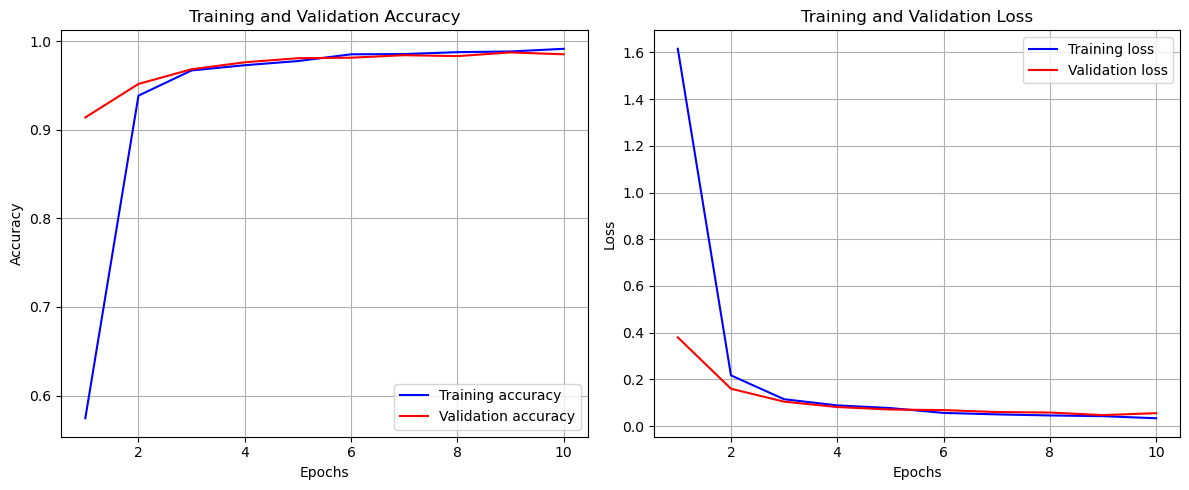

In [13]:
utils.loss_acc_plot(hist_VGGlike)

## 2.3 Build DenseNet model and train

### 2.3.1 Build model, compile and fit

In [14]:
# Define the CNN model
DenseNet = Sequential()
DenseNet.add(layers.Dense(64,input_shape= input_shape, activation='relu'))
DenseNet.add(layers.Dense(128, activation='relu'))
DenseNet.add(layers.Dense(256, activation='relu'))
DenseNet.add(layers.Flatten())
DenseNet.add(layers.Dense(10, activation='softmax'))

DenseNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64, 64, 64)        128       
                                                                 
 dense_2 (Dense)             (None, 64, 64, 128)       8320      
                                                                 
 dense_3 (Dense)             (None, 64, 64, 256)       33024     
                                                                 
 flatten_1 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_4 (Dense)             (None, 10)                10485770  
                                                                 
Total params: 10527242 (40.16 MB)
Trainable params: 10527242 (40.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
optimiseur = tf.keras.optimizers.Adam(learning_rate=lr)
optimiseur.build(DenseNet.trainable_variables)
DenseNet.compile(optimizer=optimiseur, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Train
t3 = datetime.now()
hist_DenseNet = DenseNet.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, validation_data=(x_val, y_val),shuffle=True, workers = 20)
t4 = datetime.now()
duree_dense = t4-t3

Epoch 1/10
80/80 [==============================] - 156s 2s/step - loss: 0.7910 - accuracy: 0.8184 - val_loss: 0.1919 - val_accuracy: 0.9551
Epoch 2/10
80/80 [==============================] - 155s 2s/step - loss: 0.1249 - accuracy: 0.9705 - val_loss: 0.0969 - val_accuracy: 0.9741
Epoch 3/10
80/80 [==============================] - 155s 2s/step - loss: 0.0689 - accuracy: 0.9832 - val_loss: 0.0771 - val_accuracy: 0.9796
Epoch 4/10
80/80 [==============================] - 154s 2s/step - loss: 0.0493 - accuracy: 0.9877 - val_loss: 0.0528 - val_accuracy: 0.9859
Epoch 5/10
80/80 [==============================] - 155s 2s/step - loss: 0.0382 - accuracy: 0.9910 - val_loss: 0.0454 - val_accuracy: 0.9889
Epoch 6/10
80/80 [==============================] - 155s 2s/step - loss: 0.0297 - accuracy: 0.9927 - val_loss: 0.0418 - val_accuracy: 0.9895
Epoch 7/10
80/80 [==============================] - 155s 2s/step - loss: 0.0279 - accuracy: 0.9929 - val_loss: 0.0317 - val_accuracy: 0.9924
Epoch 8/10
80

In [17]:
print(duree_dense)

0:25:52.331376


### 2.3.2 Evaluate by test set

In [18]:
DenseNet.evaluate(x_test,y_test,verbose = 1)

94/94 [==============================] - 7s 78ms/step - loss: 0.0303 - accuracy: 0.9917


[0.03025675192475319, 0.9916666746139526]

### 2.3.3 Plot accuracy and loss over epochs

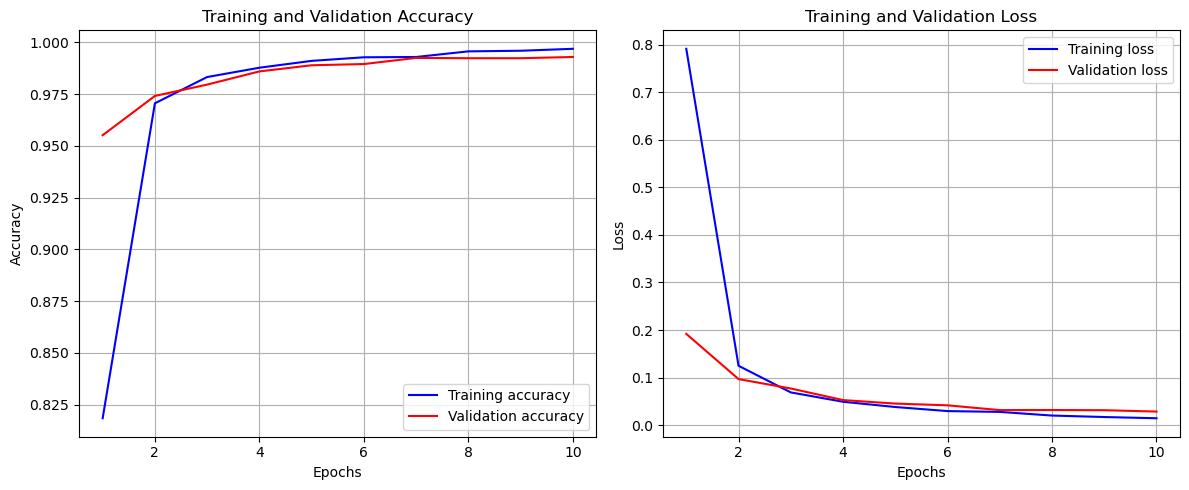

In [19]:
utils.loss_acc_plot(hist_DenseNet)

# 3. Analyse after trained

## 3.1 Prediction of models

In [20]:
class_name_all = ['0','1','2','3','4','5','6','7','8','9'] 
idx = np.random.randint(0,len(x_test))
im_test = x_test[idx]
im_test = np.expand_dims(im_test, axis=0)
predictions = DenseNet.predict(im_test)
predicted_class = np.argmax(predictions)

print(f'Predicted Class: {class_name_all[predicted_class]}')
print(f'Exact Class : {y_test[idx]}')

1/1 [==============================] - 0s 130ms/step
Predicted Class: 2
Exact Class : 2


In [21]:
# Finding the corresponding index in the original dataset
corr_index = np.where((data_load == x_test[idx]).all(axis=1))[0]
print(corr_index[0])
print(image_paths[corr_index[0]])
utils.spectrogram2audio(image_paths[corr_index[0]], path_save = '')

7158
data_img\2_24_16.tiff


In [22]:
Audio('retrodata_img/'+ image_paths[corr_index[0]][9:-5] +'.wav')

# 3.2 Full report (Precision, Recal ,F1 score)

In [23]:
proba_predictions = DenseNet.predict(x_test)
predictions = np.argmax(proba_predictions, axis=1)

# Calculate the classification report with class names
report = classification_report(y_test, predictions, target_names=class_name_all)
print(report)

94/94 [==============================] - 6s 66ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       300
           1       0.97      0.99      0.98       300
           2       1.00      0.99      0.99       300
           3       0.98      0.99      0.99       300
           4       0.99      0.99      0.99       300
           5       1.00      0.99      0.99       300
           6       1.00      1.00      1.00       300
           7       0.99      0.99      0.99       300
           8       0.99      1.00      1.00       300
           9       1.00      0.98      0.99       300

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



## 3.3 Confusion matrix

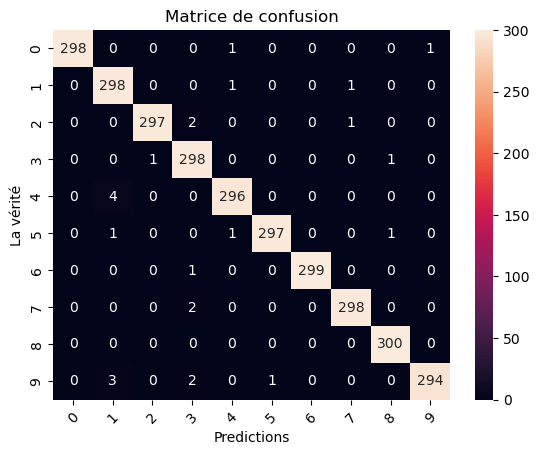

In [24]:
conf_mat = confusion_matrix(y_test,predictions)
sns.heatmap(conf_mat ,fmt='g',annot = True , xticklabels=class_name_all , yticklabels= class_name_all,)
plt.xlabel('Predictions')
plt.ylabel('La vérité')
plt.title('Matrice de confusion')
plt.xticks(rotation = 45)
plt.show()

## 3.4 DenseNet + VGGlike comparaison

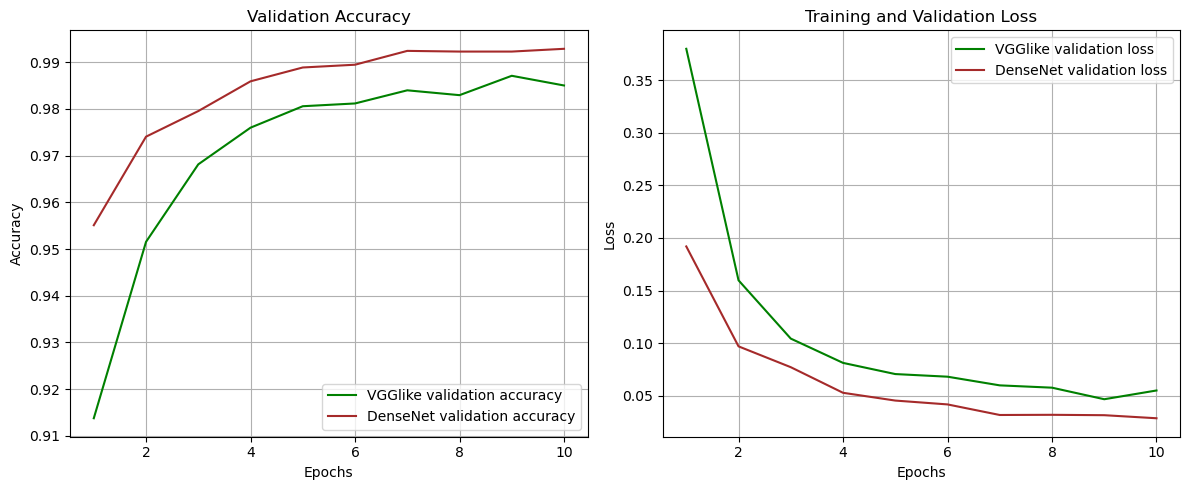

In [25]:
# Access accuracy and loss from the history object
val_loss_vgglike = hist_VGGlike.history['val_loss']
val_acc_vgglike = hist_VGGlike.history['val_accuracy']

val_loss_densenet = hist_DenseNet.history['val_loss']
val_acc_densenet = hist_DenseNet.history['val_accuracy']

epochs = range(1, len(val_loss_vgglike) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 5))

# Plotting accuracy (1st subplot)
plt.subplot(1, 2, 1)
plt.plot(epochs, val_acc_vgglike, 'green', label='VGGlike validation accuracy')
plt.plot(epochs, val_acc_densenet, 'brown', label='DenseNet validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

# Plotting loss (2nd subplot)
plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss_vgglike, 'green', label='VGGlike validation loss')
plt.plot(epochs, val_loss_densenet, 'brown', label='DenseNet validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
from keras.utils import plot_model

In [27]:
plot_model(VGGlike, to_file='VGGlike.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Note: you may need to restart the kernel to use updated packages.
